In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [3]:
import json
import pandas as pd

%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [23]:
import grader

ModuleNotFoundError: No module named 'typecheck'

In [4]:
from bokeh.io import output_notebook, reset_output

reset_output()
output_notebook()

Loading BokehJS ...

# Building a Dashboard

In this miniproject, we're going to build an interactive web "Bus dashboard" app utilizing NYC's transit data. As such, we'll be focusing on explanatory visualization.

- We're going to use [Bokeh](http://bokeh.pydata.org/en/latest/) to power our dashboard. 
- We'll use [Heroku](https://devcenter.heroku.com/articles/python-gunicorn) and [Flask](http://flask.pocoo.org/) for our web stack.
- If you're a Fellow or Scholar, you'll recognize this stack from the 12-day milestone project. 
- The miniproject contains plenty of room to expermient front-end web technologies such as [Leaflet.js](http://leafletjs.com/) and [D3.js](https://d3js.org). If you're comfortable with Bokeh, consider trying these new technologies to broaden your skillset.

Unlike some of the other miniprojects, this one is a bit less structured. The below outline and sample app are meant as a guideline. If there's a particular direction you'd like to explore with this data, by all means submit some custom visualizations! If you prefer, feel free to visualize the open bus data in your city of choice.

## Dataset and Plan [Do ASAP: Request Developer Access from MTA]

We're going to use an [Archive of transit data](http://data.beta.nyc/dataset/unofficial-mta-transit-data-archive/resource/106dd52f-8755-40a0-aa3d-dfa6195a8d21) and the [Live Feed](http://bustime.mta.info/wiki/Developers/Index/) of MTA Bus data (you'll need to request an API key, stop reading and fill out the form for this now!).

- The former is useful for determining overall reliability of a given bus line at a given time/location, the latter is useful for live stop information, of course!

- Aside from the archived bus time data, also extremely useful is the [GTFS data](https://developers.google.com/transit/gtfs/) in the Archive (under the `gtfs` folder). This includes scheduled departure times, route information, stop ID locations, etc.


- Want a pre-filtered dataset to play with some visualizations? We've got you covered.
`s3://dataincubator-course/viz-miniproject/manhattan.csv` contains 7 days' of nicely filtered data joined to some basic stop information.


## An overview of the data 

### Historical Data
The historical archive of data includes archives of real-time bus information (positions for each bus at a given time) as well as schedule data for each bus trip. It's a little messy. If you're using our dataset, you can use the following snippet to quickly load the data with datetime indices.

In [6]:
date_format_str = "%Y-%m-%d %H:%M:%S"
date_parser = lambda u: pd.datetime.strptime(u, date_format_str)
df = pd.read_csv("manhattan.csv",  
                 parse_dates=True,
                 date_parser=date_parser,
                 index_col=0,
                 usecols=range(1,18)) # peek into the csv: col 0 is 'timestamp'

In [7]:
df.head()

,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id
timestamp,,,,,,,,,,,,,,,,
2015-09-12 19:00:00,5704,40.763499,-73.967259,233.74,0,20150912,OH_D5-Saturday-116200_M101_131,1,404171.0,5714.52,179.13,M103,OH_D5-Saturday,CITY HALL via LEX AV,1,M1030181
2015-09-12 19:00:00,5984,40.802630,-73.933431,304.81,0,20150912,MQ_D5-Saturday-115200_SBS60_26,1,503357.0,8858.4,4706.79,M60+,MQ_D5-Saturday,LA GUARDIA AIRPORT,0,SBS600019
2015-09-12 19:00:00,3859,40.780305,-73.985666,157.22,0,20150912,MV_D5-Saturday-110000_M5_247,1,404289.0,10310.04,205.43,M5,MV_D5-Saturday,WASHINGTON HTS - GW BRIDGE,0,M050309
2015-09-12 19:00:00,3846,40.858229,-73.925850,175.71,2,20150912,MV_D5-Saturday-120600_M3_222,1,403466.0,259.38,226.62,M3,MV_D5-Saturday,125 ST ST. NICHOLAS,1,M030181
2015-09-12 19:00:00,5550,40.711773,-74.006888,193.90,2,20150912,OH_D5-Saturday-110200_M101_125,1,903146.0,12681.69,42.33,M103,OH_D5-Saturday,CITY HALL via LEX AV,1,M1030181


### Live Data 
This data is similarly formatted to the historical data, except live-updating every ~30 seconds (dependent on the physical bus transponders' reporting ability). You'll notice many of the values (stop IDs, trip IDs) fortunately use the same GTFS identifying information, so we can join without too much trouble (this is _not_ a given with open government data). We leave this as an exercise. The `VehicleMonitoring` endpoint ([link](http://bustime.mta.info/wiki/Developers/SIRIVehicleMonitoring)) is particularly useful.

Here's some more code that will make your life easier - once you have an API key, fill that out along with the `MTA_API_BASE` constant and you should be able to query the API without too much extra code.

In [8]:
def _flatten_dict(root_key, nested_dict, flattened_dict):
    for key, value in nested_dict.items():
        next_key = root_key + "_" + key if root_key != "" else key
        if isinstance(value, dict):
            _flatten_dict(next_key, value, flattened_dict)
        else:
            flattened_dict[next_key] = value
    return flattened_dict
    
MTA_API_KEY = '4068c7fe-58e1-4faf-ab77-9342f943fdac'
MTA_API_BASE = "http://bustime.mta.info/api/siri/vehicle-monitoring.json"
    
#This is useful for the live MTA Data
params = {"key": MTA_API_KEY, "MaximumStopVisits":2}
def nyc_current():
    resp = requests.get(MTA_API_BASE, params=params).json()
    info = resp['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['VehicleActivity']
    return pd.DataFrame([_flatten_dict('', i, {}) for i in info])

In [111]:
test = nyc_current()

In [113]:
test.head()

,MonitoredVehicleJourney_Bearing,MonitoredVehicleJourney_BlockRef,MonitoredVehicleJourney_DestinationName,MonitoredVehicleJourney_DestinationRef,MonitoredVehicleJourney_DirectionRef,MonitoredVehicleJourney_FramedVehicleJourneyRef_DataFrameRef,MonitoredVehicleJourney_FramedVehicleJourneyRef_DatedVehicleJourneyRef,MonitoredVehicleJourney_JourneyPatternRef,MonitoredVehicleJourney_LineRef,MonitoredVehicleJourney_Monitored,...,MonitoredVehicleJourney_OriginAimedDepartureTime,MonitoredVehicleJourney_OriginRef,MonitoredVehicleJourney_ProgressRate,MonitoredVehicleJourney_ProgressStatus,MonitoredVehicleJourney_PublishedLineName,MonitoredVehicleJourney_SituationRef,MonitoredVehicleJourney_VehicleLocation_Latitude,MonitoredVehicleJourney_VehicleLocation_Longitude,MonitoredVehicleJourney_VehicleRef,RecordedAtTime
0,192.235080,MTA NYCT_JA_D7-Weekday-SDon_E_JA_76020_Q5-19,JAMAICA PRSNS-ARCHR via MERRICK,MTA_904005,1,2017-10-16,MTA NYCT_JA_D7-Weekday-SDon-142000_Q5_19,MTA_Q050189,MTA NYCT_Q5,True,...,2017-10-17T00:28:00.000-04:00,MTA_503105,noProgress,layover,Q5,[],40.701546,-73.803727,MTA NYCT_8422,2017-10-17T00:17:30.000-04:00
1,304.884250,MTA NYCT_CS_D7-Weekday-SDon_E_CS_79800_MISC-820,LAGUARDIA AIRPORT,MTA_904050,1,2017-10-16,MTA NYCT_CS_D7-Weekday-SDon-143000_MISC_820,MTA_Q480078,MTA NYCT_Q48,True,...,NaN,MTA_904190,normalProgress,NaN,Q48,[],40.768631,-73.864751,MTA NYCT_4198,2017-10-17T00:17:29.000-04:00
2,54.017395,MTA NYCT_OF_D7-Weekday-SDon_E_OF_46740_M1-119,HARLEM 147 ST via 6 AV via AMSTERDAM,MTA_803003,0,2017-10-16,MTA NYCT_OF_D7-Weekday-SDon-145000_M1_150,MTA_M070087,MTA NYCT_M7,True,...,NaN,MTA_400726,normalProgress,NaN,M7,[],40.743510,-73.992362,MTA NYCT_3831,2017-10-17T00:17:18.132-04:00
3,101.121460,MTA NYCT_FB_D7-Weekday-SDon_E_FB_84420_B49-42,BD-STY FLTN ST via OCEAN AV via ROGRS AV,MTA_901087,0,2017-10-16,MTA NYCT_FB_D7-Weekday-SDon-143000_B49_42,MTA_B49O0109,MTA NYCT_B49,True,...,NaN,MTA_308159,normalProgress,NaN,B49,[],40.628094,-73.956844,MTA NYCT_4960,2017-10-17T00:17:22.000-04:00
4,14.371583,MTA NYCT_YU_D7-Weekday-SDon_E_YU_60_S6292-1,ST GEORGE FERRY via VICTORY,MTA_805014,0,2017-10-17,MTA NYCT_YU_D7-Weekday-SDon-002000_S6292_1,MTA_S620099,MTA NYCT_S62,True,...,2017-10-17T00:20:00.000-04:00,MTA_203175,noProgress,layover,S62,[],40.587066,-74.198687,MTA NYCT_8313,2017-10-17T00:17:43.000-04:00


In [128]:
test.shape

(764, 30)

## Part 1: Initial Setup / Getting an App Live

Your first step should be setting up a skeleton app with Flask and Bokeh. [This repository](https://github.com/thedataincubator/flask-demo) is a good place to start. 

One important note: we've found that the conda buildpack provided in that repository consumes lots of space during compilation (and runs up against heroku space limitations quickly). We've had good luck with this [numpy / scipy buildpack](https://github.com/thenovices/heroku-buildpack-scipy) (nb. once you have numpy, you have pandas). Using this buildpack, we were able to push the 80MB `manhattan.csv` file provided above as a static, low-fuss database that we load into pandas during app start.

In [45]:
!pip freeze | grep bokeh
!pip freeze | grep pandas

bokeh==0.12.7
pandas==0.20.3


## Part 2: Plot Some Data [Python]
Let's start our dashboard with a simple visualization: the number of unique buses on the road at any given time. 
- Download 4-5 days' worth of data from this [archive of live updates](http://data.mytransit.nyc/bus_time/) (or use our pre-filtered dataset).
- `vehicle_id` contains a number that uniquely identifies each vehicle on the road that's currently reporting information. You'll want to count this value to determine how many buses are on the road.
- You'll want to sample counts at some fixed interval (e.g. every 15mins, 30mins, or 1hr). The granularity is up to you. Our pre-filtered dataset takes ~3 minute windows every 15 minutes.

** Your visualization should**:
1. Display a count of currently reporting vehicles at each time within a user-selected interval (eg. 2015-01-28 from 9AM EST to 12PM EST)
2. Allow the user to select different days and intervals. 
3. Another interesting visualization might be a simple histogram of the distribution of sampled counts. What does this distribution look like? Following up with this histogram, can you create another visualization to explain the trends you're seeing in count frequency?

**Making this production-ready**:
If you do this miniproject "from scratch" (ie downloading and processing the data manually), you'll quickly find that you cannot deploy the entire dataset to heroku. You'll need to just provide the relevant, processed data for your visualization when you upload.

In [312]:
vehicle_id = df['vehicle_id']
bus_counts = vehicle_id.resample('15T', base=0, closed='left').agg(pd.Series.nunique) #base is like an offset, closed 'left' says include left edge of bin interval
# use .agg(pd.Series.nunique) instead of .nunique() because of weird Pandas bug
bus_counts = bus_counts.reset_index()
bus_counts.rename(index=str, columns={'vehicle_id':'bus_counts'}, inplace=True)

In [313]:
bus_counts.head()

,timestamp,bus_counts
0,2015-09-12 19:00:00,292
1,2015-09-12 19:15:00,285
2,2015-09-12 19:30:00,276
3,2015-09-12 19:45:00,260
4,2015-09-12 20:00:00,254


In [121]:
from bokeh.layouts import column
from bokeh.models import *
from bokeh.util.string import *
from bokeh.plotting import figure, show
from bokeh.models.widgets import RangeSlider
from datetime import datetime
from bokeh.core.properties import *

source = ColumnDataSource(bus_counts)

start = bus_counts['timestamp'].iloc[0].to_pydatetime()
end = bus_counts['timestamp'].iloc[-1].to_pydatetime()

plot = figure(plot_width=800, plot_height=400, x_axis_type="datetime")
plot.line('timestamp','bus_counts',source=source, line_width=3, line_alpha=0.6)

callback = CustomJS(args=dict(p=plot, xr=plot.x_range), code="""
    var f = cb_obj.value
    xr.start = f[0];
    xr.end = f[1];
    
    p.change.emit();
""")

range_slider = DateRangeSlider(value=(start, end), start=start, end=end, callback_policy='mouseup')
range_slider.js_on_change('value', callback)
layout = column(range_slider, plot)

show(layout)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a86cda0>]], dtype=object)

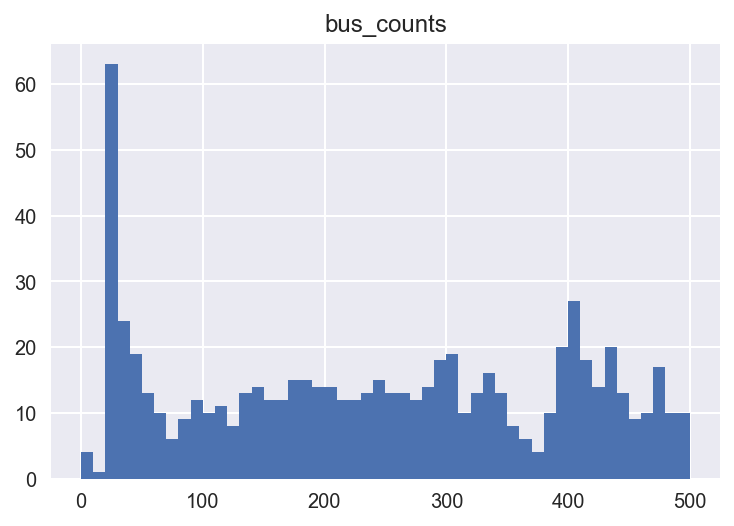

In [124]:
bus_counts.hist(bins=np.arange(0,510,10))

In [ ]:
def counts_by_hour():
    return "http://a-b-c.herokuapp.com"

grader.score('viz__counts_by_hour', counts_by_hour)

## Part 3: Integrating Live Data [Python]

Now, add in the information from the live `VehicleMonitoring` endpoint. 

**Your visualization should** 
1. Display how many buses are currently on the road.
2. Compare current bus counts with historical data - maybe download more days and aggregate counts (once you have the code to extract counts from one `.csv` file, you should be able to extract counts from any number of the `.csv` archive files. 
3. Consider adding a chart that groups by borough or route. A [box and whisker](http://www.datavizcatalogue.com/methods/box_plot.html) plot might be useful to help us understand the current vehicle count in the context of historical bus data.

In [314]:
bus_data_now = nyc_current()

In [315]:
bus_data_now.head()

,MonitoredVehicleJourney_Bearing,MonitoredVehicleJourney_BlockRef,MonitoredVehicleJourney_DestinationName,MonitoredVehicleJourney_DestinationRef,MonitoredVehicleJourney_DirectionRef,MonitoredVehicleJourney_FramedVehicleJourneyRef_DataFrameRef,MonitoredVehicleJourney_FramedVehicleJourneyRef_DatedVehicleJourneyRef,MonitoredVehicleJourney_JourneyPatternRef,MonitoredVehicleJourney_LineRef,MonitoredVehicleJourney_Monitored,...,MonitoredVehicleJourney_OriginAimedDepartureTime,MonitoredVehicleJourney_OriginRef,MonitoredVehicleJourney_ProgressRate,MonitoredVehicleJourney_ProgressStatus,MonitoredVehicleJourney_PublishedLineName,MonitoredVehicleJourney_SituationRef,MonitoredVehicleJourney_VehicleLocation_Latitude,MonitoredVehicleJourney_VehicleLocation_Longitude,MonitoredVehicleJourney_VehicleRef,RecordedAtTime
0,196.676380,MTA NYCT_CS_D7-Weekday-SDon_E_CS_49200_MISC-787,BAYSIDE 27 AV F LEWIS BL,MTA_804051,0,2017-10-18,MTA NYCT_CS_D7-Weekday-SDon-085000_MISC_787,MTA_Q310010,MTA NYCT_Q31,True,...,NaN,MTA_804084,normalProgress,NaN,Q31,[],40.769113,-73.791303,MTA NYCT_7424,2017-10-18T14:42:09.965-04:00
1,337.236700,MTA NYCT_MV_D7-Weekday-SDon_E_MV_23940_M2-111,LTD EAST VILLAGE 8 ST via 5 AV,MTA_403793,1,2017-10-18,MTA NYCT_MV_D7-Weekday-SDon-081700_M2_135,MTA_M020190,MTA NYCT_M2,True,...,NaN,MTA_903049,normalProgress,NaN,M2,[{'SituationSimpleRef': 'MTA NYCT_77041'}],40.797259,-73.950121,MTA NYCT_3846,2017-10-18T14:43:11.000-04:00
2,328.786680,MTA NYCT_JG_D7-Weekday-SDon_E_JG_41580_B11-24,MIDWOOD FLATBUSH AV,MTA_306468,0,2017-10-18,MTA NYCT_JG_D7-Weekday-SDon-085000_B11_19,MTA_B110033,MTA NYCT_B11,True,...,NaN,MTA_307484,normalProgress,NaN,B11,[],40.628320,-73.982526,MTA NYCT_406,2017-10-18T14:43:12.000-04:00
3,54.125546,MTA NYCT_YU_D7-Weekday-SDon_E_YU_46800_X109-50,W MDTWN CNTRL PK S. via CHURCH via 6 AV,MTA_903036,0,2017-10-18,MTA NYCT_YU_D7-Weekday-SDon-078500_X109_50,MTA_X10400,MTA NYCT_X1,True,...,NaN,MTA_202097,normalProgress,NaN,X1,[],40.760354,-73.980095,MTA NYCT_2693,2017-10-18T14:43:30.000-04:00
4,5.525326,MTA NYCT_QV_D7-Weekday-SDon_E_QV_16440_Q27-5,CAMBRIA HTS 120 AV,MTA_804044,1,2017-10-18,MTA NYCT_QV_D7-Weekday-SDon-085700_MISC_209,MTA_Q270872,MTA NYCT_Q27,True,...,NaN,MTA_804017,normalProgress,NaN,Q27,[{'SituationSimpleRef': 'MTA NYCT_152128'}],40.752610,-73.785296,MTA NYCT_4663,2017-10-18T14:43:28.000-04:00


In [316]:
bus_data_now.shape

(2963, 30)

In [317]:
date_format_str = "%Y-%m-%dT%H:%M:%S.%f"
date_parser = lambda u: pd.to_datetime(u[0:-6], format=date_format_str)
bus_data_now = bus_data_now.loc[:,('MonitoredVehicleJourney_VehicleRef','RecordedAtTime')]
bus_data_now.rename(index=str, columns={'MonitoredVehicleJourney_VehicleRef':'vehicle_id','RecordedAtTime':'timestamp'}, inplace=True)
bus_data_now.loc[:,'timestamp']=bus_data_now.loc[:,'timestamp'].apply(date_parser)


In [318]:
bus_data_now.loc[:,'vehicle_id']=bus_data_now.loc[:,'vehicle_id'].apply(lambda u: int(u.split('_')[1]))

In [319]:
bus_data_now=bus_data_now.set_index(['timestamp'])

In [320]:
bus_data_now['vehicle_id'].nunique()

2963

In [321]:
bus_counts_now = bus_data_now.resample('15T', base=0, closed='left').agg(pd.Series.nunique) #base is like an offset, closed 'left' says include left edge of bin interval
# use .agg(pd.Series.nunique) instead of .nunique() because of weird Pandas bug
bus_counts_now = bus_counts_now.reset_index()
bus_counts_now.rename(index=str, columns={'vehicle_id':'bus_counts'}, inplace=True)

In [322]:
bus_counts_now

,timestamp,bus_counts
0,2017-10-18 14:30:00,2963


In [323]:
bus_data_now.index.max()

Timestamp('2017-10-18 14:44:47.610000')

In [324]:
bus_data_now.index.min()

Timestamp('2017-10-18 14:41:23')

In [325]:
bus_data_now['timeframe']='2017-10'

In [326]:
bus_counts['timeframe']='2015-09'

In [327]:
bus_counts = bus_counts.append(bus_counts_now)

In [329]:
bus_counts.reset_index(inplace=True)

In [333]:
bus_counts.loc[768,'timeframe']='2017-10'

In [335]:
bus_counts = bus_counts.drop(labels='index',axis=1)

In [336]:
bus_counts

,bus_counts,timeframe,timestamp
0,292,2015-09,2015-09-12 19:00:00
1,285,2015-09,2015-09-12 19:15:00
2,276,2015-09,2015-09-12 19:30:00
3,260,2015-09,2015-09-12 19:45:00
4,254,2015-09,2015-09-12 20:00:00
5,253,2015-09,2015-09-12 20:15:00
6,245,2015-09,2015-09-12 20:30:00
7,235,2015-09,2015-09-12 20:45:00
8,232,2015-09,2015-09-12 21:00:00
9,224,2015-09,2015-09-12 21:15:00


In [342]:
date_format_str = "%Y-%m-%dT%H:%M:%S"
date_parser = lambda u: pd.datetime.strptime(u[0:-1], date_format_str)
df = pd.read_csv("bus_time_20160630.csv",
                parse_dates=True,
                date_parser=date_parser,
                index_col=0,
                usecols=range(0,2)) # peek into the csv: col 0 is 'timestamp'
df = df.resample('15T', base=0, closed='left').agg(pd.Series.nunique) #base is like an offset, closed 'left' says include left edge of bin interval
# use .agg(pd.Series.nunique) instead of .nunique() because of weird Pandas bug
df = df.reset_index()
df.rename(index=str, columns={'vehicle_id':'bus_counts'}, inplace=True)
df['timeframe']='2016-06'

In [343]:
bus_counts = bus_counts.append(df)

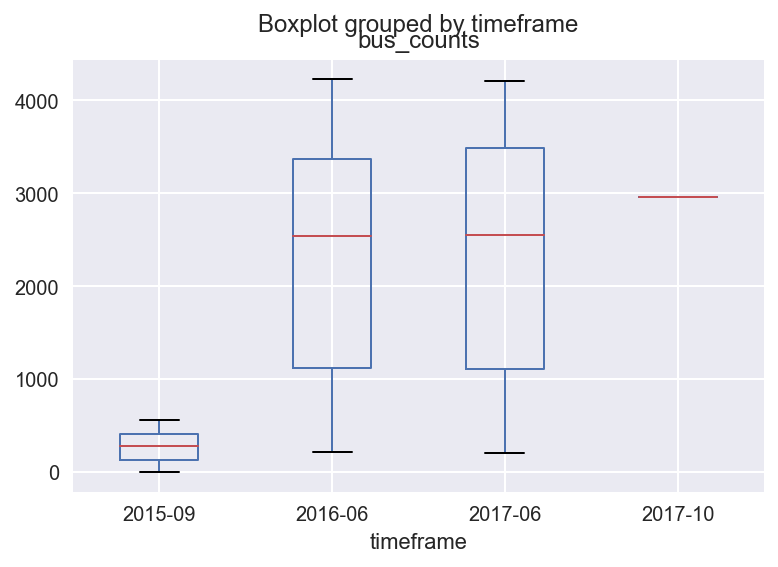

In [344]:
ax = bus_counts.boxplot(column='bus_counts',by='timeframe')

In [ ]:
def live_count_boxplot():
    return "http://a-b-c.herokuapp.com"

grader.score('viz__live_count_boxplot', live_count_boxplot)

## Part 4: Map some data [JS, Python]

Using the dataset's geolocation information, let's make a heatmap of bus positions at a given time.

You can do this in a fully web-based way using the following stack:

**Frontend**
- [Leaflet.js](http://leafletjs.com/)
- [Leaflet.heat](https://github.com/Leaflet/Leaflet.heat)
- [D3.js](https://d3js.org/)

**Backend**
- Pandas

Your frontend code should use D3 to asynchronously query the server/load the location points for buses at a specified time. From there, pass those points into a Leaflet heatmap.

In [9]:
import ihtml

In [10]:
bus_locations = nyc_current()

In [11]:
bus_locations = bus_locations.loc[:,('MonitoredVehicleJourney_VehicleLocation_Latitude','MonitoredVehicleJourney_VehicleLocation_Longitude')]
bus_locations.rename(index=str, columns={'MonitoredVehicleJourney_VehicleLocation_Latitude':'lat','MonitoredVehicleJourney_VehicleLocation_Longitude':'long'}, inplace=True)

In [ ]:
# should modify to check that these are unique buses

In [12]:
bus_locs = bus_locations.values.tolist()

In [13]:
%%ihtml
<!DOCTYPE html>
<html>
  <head>
    <meta charset="utf-8">
    <title>Leaflet Bus Heatmap</title>
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.2.0/dist/leaflet.css" integrity="sha512-M2wvCLH6DSRazYeZRIm1JnYyh22purTM+FDB5CsyxtQJYeKq83arPe5wgbNmcFXGqiSH2XR8dT/fJISVA1r/zQ==" crossorigin=""/>
    <script src="https://unpkg.com/leaflet@1.2.0/dist/leaflet.js" integrity="sha512-lInM/apFSqyy1o6s89K4iQUKg6ppXEgsVxT35HbzUupEVRh2Eu9Wdl4tHj7dZO0s1uvplcYGmt3498TtHq+log==" crossorigin=""></script>
    <script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>
    <script src="http://leaflet.github.io/Leaflet.heat/dist/leaflet-heat.js"></script>
    <style>
      #mapid { 
          width: 800px;
          height: 300px; 
        }
    </style>
  </head>

  <body>
    <h1>Leaflet Bus Heatmap</h1>
    <div id="mapid"></div>
    <script>
        var mymap = L.map('mapid').setView([40.75, -73.8], 10);
        L.tileLayer('https://api.tiles.mapbox.com/v4/{id}/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw', {
        maxZoom: 18,
        attribution: 'Map data &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, ' +
            '<a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, ' +
            'Imagery © <a href="http://mapbox.com">Mapbox</a>',
            id: 'mapbox.streets'
        }).addTo(mymap);
        
        var busLocations = {{ bus_locs }}
        
        var heat = L.heatLayer(busLocations, {radius: 20, 
            maxzoom: 18
        }).addTo(mymap);
    </script>
  </body>
</html>

<iframe
 width="100%"
 height="400"
 src="data:text/html;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgogIDxoZWFkPgogICAgPG1ldGEgY2hhcnNldD0idXRmLTgiPgogICAgPHRpdGxlPkxlYWZsZXQgQnVzIEhlYXRtYXA8L3RpdGxlPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3VucGtnLmNvbS9sZWFmbGV0QDEuMi4wL2Rpc3QvbGVhZmxldC5jc3MiIGludGVncml0eT0ic2hhNTEyLU0yd3ZDTEg2RFNSYXpZZVpSSW0xSm5ZeWgyMnB1clRNK0ZEQjVDc3l4dFFKWWVLcTgzYXJQZTV3Z2JObWNGWEdxaVNIMlhSOGRUL2ZKSVNWQTFyL3pRPT0iIGNyb3Nzb3JpZ2luPSIiLz4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL3VucGtnLmNvbS9sZWFmbGV0QDEuMi4wL2Rpc3QvbGVhZmxldC5qcyIgaW50ZWdyaXR5PSJzaGE1MTItbEluTS9hcEZTcXl5MW82czg5SzRpUVVLZzZwcFhFZ3NWeFQzNUhielV1cEVWUmgyRXU5V2RsNHRIajdkWk8wczF1dnBsY1lHbXQzNDk4VHRIcStsb2c9PSIgY3Jvc3NvcmlnaW49IiI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9kM2pzLm9yZy9kMy52My5taW4uanMiIGNoYXJzZXQ9InV0Zi04Ij48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwOi8vbGVhZmxldC5naXRodWIuaW8vTGVhZmxldC5oZWF0L2Rpc3QvbGVhZmxldC1oZWF0LmpzIj48L3NjcmlwdD4KICAgIDxzdHlsZT4KICAgICAgI21hcGlkIHsgCiAgICAgICAgICB3aWR0aDogODAwcHg7CiAgICAgICAgICBoZWlnaHQ6IDMwMHB4OyAKICAgICAgICB9CiAgICA8L3N0eWxlPgogIDwvaGVhZD4KCiAgPGJvZHk+CiAgICA8aDE+TGVhZmxldCBCdXMgSGVhdG1hcDwvaDE+CiAgICA8ZGl2IGlkPSJtYXBpZCI+PC9kaXY+CiAgICA8c2NyaXB0PgogICAgICAgIHZhciBteW1hcCA9IEwubWFwKCdtYXBpZCcpLnNldFZpZXcoWzQwLjc1LCAtNzMuOF0sIDEwKTsKICAgICAgICBMLnRpbGVMYXllcignaHR0cHM6Ly9hcGkudGlsZXMubWFwYm94LmNvbS92NC97aWR9L3t6fS97eH0ve3l9LnBuZz9hY2Nlc3NfdG9rZW49cGsuZXlKMUlqb2liV0Z3WW05NElpd2lZU0k2SW1OcGVqWTROWFZ5Y1RBMmVtWXljWEJuZEhScWNtWjNOM2dpZlEuckpjRklHMjE0QXJpSVNMYkI2QjVhdycsIHsKICAgICAgICBtYXhab29tOiAxOCwKICAgICAgICBhdHRyaWJ1dGlvbjogJ01hcCBkYXRhICZjb3B5OyA8YSBocmVmPSJodHRwOi8vb3BlbnN0cmVldG1hcC5vcmciPk9wZW5TdHJlZXRNYXA8L2E+IGNvbnRyaWJ1dG9ycywgJyArCiAgICAgICAgICAgICc8YSBocmVmPSJodHRwOi8vY3JlYXRpdmVjb21tb25zLm9yZy9saWNlbnNlcy9ieS1zYS8yLjAvIj5DQy1CWS1TQTwvYT4sICcgKwogICAgICAgICAgICAnSW1hZ2VyeSDCqSA8YSBocmVmPSJodHRwOi8vbWFwYm94LmNvbSI+TWFwYm94PC9hPicsCiAgICAgICAgICAgIGlkOiAnbWFwYm94LnN0cmVldHMnCiAgICAgICAgfSkuYWRkVG8obXltYXApOwogICAgICAgIAogICAgICAgIHZhciBidXNMb2NhdGlvbnMgPSBbWzQwLjc3ODUyNSwgLTczLjk3NDI3XSwgWzQwLjkxMDQ3NSwgLTczLjkwMzEyM10sIFs0MC42ODc0ODUsIC03My45ODYyNjNdLCBbNDAuNzAwMTQ5LCAtNzMuOTExNTkyXSwgWzQwLjcxMTAxNCwgLTczLjk1MDUwNV0sIFs0MC44NDY2MSwgLTczLjg4MzkzNF0sIFs0MC43NTE4NjcsIC03My45NzcwN10sIFs0MC43ODQyMiwgLTczLjg0NTUyOF0sIFs0MC42ODQzNzYsIC03My45NTAzNzRdLCBbNDAuNjc4MzkxLCAtNzMuOTQ5N10sIFs0MC42NDI5MjksIC03NC4wNzQwMjJdLCBbNDAuNjk4ODcyLCAtNzMuOTE3NzI2XSwgWzQwLjY2OTI1LCAtNzMuODYzMTExXSwgWzQwLjg2OTQ4OCwgLTczLjg5NTgzNV0sIFs0MC44Mzk1NDgsIC03My45MTMwNzJdLCBbNDAuNzM4MjczLCAtNzMuOTgxODI0XSwgWzQwLjgzMTE0NCwgLTczLjkwNjExXSwgWzQwLjg0OTc2NiwgLTczLjkwNTk3Nl0sIFs0MC43MTgxODYsIC03My45OTA3NzddLCBbNDAuODkzNTMsIC03My44OTY0NjRdLCBbNDAuNjUyMjA4LCAtNzMuOTI4Mjc5XSwgWzQwLjY3MDY4MiwgLTczLjkxNDUyN10sIFs0MC43NTc5NjEsIC03My44MzYyMjldLCBbNDAuNzc0NTQyLCAtNzMuOTU3OTExXSwgWzQwLjg3MDA4NCwgLTczLjg0NTUwMl0sIFs0MC43MDU1NiwgLTczLjg5NjQ3Ml0sIFs0MC44NzkyMDYsIC03My45MDUzNzRdLCBbNDAuNzAxNDc4LCAtNzMuODg2NDZdLCBbNDAuNjMwNjExLCAtNzQuMDgxNzI1XSwgWzQwLjU5OTYyLCAtNzMuOTQ5MjM5XSwgWzQwLjYyMjMwNCwgLTczLjk4NzcyNF0sIFs0MC42MDI5OTcsIC03NC4wMDgxMzRdLCBbNDAuODMwNzE1LCAtNzMuOTIwMzY1XSwgWzQwLjY0MzExMywgLTc0LjA3MzQ0M10sIFs0MC43NDI0NDYsIC03My43NzkzMzJdLCBbNDAuNjQ2NDk3LCAtNzQuMDA4ODcxXSwgWzQwLjczOTY4NiwgLTczLjgxNTExOF0sIFs0MC42OTY0ODIsIC03My45Nzk0MDJdLCBbNDAuNjkxMjc5LCAtNzMuNzQ3OTE3XSwgWzQwLjY4OTc5NCwgLTczLjc0MTMzMl0sIFs0MC42NTcxMDUsIC03My44ODk2MDRdLCBbNDAuNzA5MTA4LCAtNzMuOTU5OTA2XSwgWzQwLjU3NDYxNCwgLTczLjk4NzU2N10sIFs0MC44MzQ3NjgsIC03My44Njk5NDRdLCBbNDAuODMxOTUyLCAtNzMuOTA4NTg3XSwgWzQwLjY3MDAwMiwgLTczLjkxMDgyMl0sIFs0MC44Mzg0NjksIC03My45MTMzNDNdLCBbNDAuNTg5OTkyLCAtNzMuOTY1Mzg1XSwgWzQwLjY1MTY0NiwgLTczLjkzMjM4Ml0sIFs0MC44NTcxNzQsIC03My45MzIzOV0sIFs0MC43MTUwODMsIC03My45NzY1N10sIFs0MC43NzAxNDQsIC03My44MTU3MThdLCBbNDAuNzAxNTQ2LCAtNzMuODAzNzI3XSwgWzQwLjYxMzA0LCAtNzQuMTIzMTg0XSwgWzQwLjg2NDAzNCwgLTczLjkwNDEyNV0sIFs0MC43MTMyNzYsIC03My43ODEyMTddLCBbNDAuNjMyMjQ4LCAtNzMuOTQ3NTk4XSwgWzQwLjgwNzYwOCwgLTczLjg1MjMzNF0sIFs0MC42MDY0NiwgLTczLjk4OTEyN10sIFs0MC44NTI1NTcs

In [ ]:
def map_static():
    return "http://a-b-c.herokuapp.com"

grader.score('viz__map_static', map_static)

## Part 5: Animate the plot [JS, Python]

Now, given the ability to look at the heatmap of any given time, let's suppose we want to visualize the ebb and flow of buses throughout a given day. Try animating the heatmap to develop something similar to this:
![buses](http://i.imgur.com/DIid7p7.gif)
http://arcane-shelf-99495.herokuapp.com/static/nyc_bus_info.html

In [14]:
date_format_str = "%Y-%m-%d %H:%M:%S"
date_parser = lambda u: pd.datetime.strptime(u, date_format_str)
df = pd.read_csv("manhattan.csv",  
                 parse_dates=True,
                 date_parser=date_parser,
                 index_col=0,
                 usecols=range(1,18)) # peek into the csv: col 0 is 'timestamp'

In [15]:
df.head()

,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,route_id,service_id,trip_headsign,direction_id,shape_id
timestamp,,,,,,,,,,,,,,,,
2015-09-12 19:00:00,5704,40.763499,-73.967259,233.74,0,20150912,OH_D5-Saturday-116200_M101_131,1,404171.0,5714.52,179.13,M103,OH_D5-Saturday,CITY HALL via LEX AV,1,M1030181
2015-09-12 19:00:00,5984,40.802630,-73.933431,304.81,0,20150912,MQ_D5-Saturday-115200_SBS60_26,1,503357.0,8858.4,4706.79,M60+,MQ_D5-Saturday,LA GUARDIA AIRPORT,0,SBS600019
2015-09-12 19:00:00,3859,40.780305,-73.985666,157.22,0,20150912,MV_D5-Saturday-110000_M5_247,1,404289.0,10310.04,205.43,M5,MV_D5-Saturday,WASHINGTON HTS - GW BRIDGE,0,M050309
2015-09-12 19:00:00,3846,40.858229,-73.925850,175.71,2,20150912,MV_D5-Saturday-120600_M3_222,1,403466.0,259.38,226.62,M3,MV_D5-Saturday,125 ST ST. NICHOLAS,1,M030181
2015-09-12 19:00:00,5550,40.711773,-74.006888,193.90,2,20150912,OH_D5-Saturday-110200_M101_125,1,903146.0,12681.69,42.33,M103,OH_D5-Saturday,CITY HALL via LEX AV,1,M1030181


In [16]:
monday = df.loc['2015-09-14',:] # get one day of data only

In [17]:
monday['hours']=monday.index.hour

/Users/lizottohamel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
monday['minutes']=monday.index.minute

/Users/lizottohamel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
monday = monday[['vehicle_id','latitude','longitude','hours','minutes']]

In [20]:
monday.loc[(monday.loc[:,'minutes']<15),'minutes']=0

In [21]:
monday.loc[(monday.loc[:,'minutes']>=15) & (monday.loc[:,'minutes']<30),'minutes']=15

In [22]:
monday.loc[(monday.loc[:,'minutes']>=30) & (monday.loc[:,'minutes']<45),'minutes']=30

In [23]:
monday.loc[(monday.loc[:,'minutes']>=45),'minutes']=45

In [24]:
monday = monday.reset_index()

In [25]:
monday = monday[['latitude', 'longitude','hours','minutes']]

In [26]:
monday.head()

,latitude,longitude,hours,minutes
0,40.743065,-73.993193,0,0
1,40.721217,-73.977831,0,0
2,40.733222,-73.981209,0,0
3,40.739059,-73.982982,0,0
4,40.756131,-73.961567,0,0


In [27]:
monday.shape

(61708, 4)

In [28]:
mondaytest = monday.iloc[0:20000,:]

In [29]:
mondaytest.shape

(20000, 4)

In [30]:
pandastest = pd.DataFrame({'column1':[10,20,30],'column2':[4,5,6]})
pandastest

,column1,column2
0,10,4
1,20,5
2,30,6


In [31]:
%%ihtml
<html>
    <head>
        <script>
            
        testdata = {{ mondaytest | json }};
            
        /*
        convertData = function(data){
          var convertedData = [];
          // Object.keys(data) is an array of the dataframe's column headers
          // so data[Object.keys(data)[0]] is data[column1], and the i are the indices of the items in column1, so just the row indicies
          for(var i in data[Object.keys(data)[0]]){
            var convertedDatum = {}; // {} are objects in JS, similar to Python dictionaries
            for(var key in data){ // the key are the column headers
              convertedDatum[key] = data[key][i];
            }
            if (convertedDatum.column2>5){
            convertedData.push(convertedDatum);
          }
          }
          return convertedData;
        }
        */
        
        convertData = function(data, hours, minutes){
            var convertedData = [];
            for(var i in data[Object.keys(data)[0]]){
                var convertedDatum = {}; // {} are objects in JS, similar to Python dictionaries
                for(var key in data){ // the key are the column headers
                    convertedDatum[key] = data[key][i];
                }
                if (convertedDatum.hours==hours & convertedDatum.minutes==minutes){
                    convertedData.push([+convertedDatum.latitude, +convertedDatum.longitude]);
                }
            }
            return convertedData;
        }

        $(document).ready(function() {
          var data = convertData(testdata,0,0);
            console.log(data[0])
        });
        </script>
    </head>
    <body>
    </body>
</html>

<iframe
 width="100%"
 height="400"
 src="data:text/html;base64,PGh0bWw+CiAgICA8aGVhZD4KICAgICAgICA8c2NyaXB0PgogICAgICAgICAgICAKICAgICAgICB0ZXN0ZGF0YSA9IHsibGF0aXR1ZGUiOnsiMCI6NDAuNzQzMDY1LCIxIjo0MC43MjEyMTcsIjIiOjQwLjczMzIyMiwiMyI6NDAuNzM5MDU5LCI0Ijo0MC43NTYxMzEsIjUiOjQwLjc0MDczNCwiNiI6NDAuODAyMTk3LCI3Ijo0MC43MzU2NCwiOCI6NDAuODEwNDEzLCI5Ijo0MC44MDQ2MTQsIjEwIjo0MC43NjcyMDYsIjExIjo0MC43ODI2NTEsIjEyIjo0MC43MzAyODQsIjEzIjo0MC44MDMyMjQsIjE0Ijo0MC43OTUwMDcsIjE1Ijo0MC43NjcyMTgsIjE2Ijo0MC43NTYzMjMsIjE3Ijo0MC43NTA3NTksIjE4Ijo0MC43NDM3OTEsIjE5Ijo0MC43NTkzMzgsIjIwIjo0MC43NzM1OCwiMjEiOjQwLjgyMjczNCwiMjIiOjQwLjgwNDIyMSwiMjMiOjQwLjgyMTUzNSwiMjQiOjQwLjc0NzY2NywiMjUiOjQwLjcxMzc5OCwiMjYiOjQwLjgyMTg2OCwiMjciOjQwLjc2NjQyMSwiMjgiOjQwLjcxNTk3MywiMjkiOjQwLjgxMDExLCIzMCI6NDAuNzQ1ODcxLCIzMSI6NDAuNzYyNjA4LCIzMiI6NDAuNzM3MDg5LCIzMyI6NDAuODIyMjAyLCIzNCI6NDAuNzcxOTU0LCIzNSI6NDAuNzI0NzY3LCIzNiI6NDAuNzQ0NjgsIjM3Ijo0MC44MjE0MjEsIjM4Ijo0MC43ODUzOTUsIjM5Ijo0MC44MDA2NDMsIjQwIjo0MC44MjAyMDMsIjQxIjo0MC43OTMxMDEsIjQyIjo0MC44MTQ5NCwiNDMiOjQwLjgxNDE2NCwiNDQiOjQwLjgxNzIwOSwiNDUiOjQwLjczOTYzNCwiNDYiOjQwLjcxNzM1NSwiNDciOjQwLjc3OTU5MSwiNDgiOjQwLjgxOTk5OCwiNDkiOjQwLjc3NDM2MSwiNTAiOjQwLjgwNDQwMSwiNTEiOjQwLjgzNDQ3OSwiNTIiOjQwLjg1MjUsIjUzIjo0MC43MjQzMywiNTQiOjQwLjc4MzE5NiwiNTUiOjQwLjc2NjkwMiwiNTYiOjQwLjgyMjU3LCI1NyI6NDAuNzAxNjA3LCI1OCI6NDAuODMwMjQyLCI1OSI6NDAuNzc2MDgyLCI2MCI6NDAuNzY2OTU4LCI2MSI6NDAuNzY2NjU3LCI2MiI6NDAuNzQ5OTA3LCI2MyI6NDAuODY2NDcxLCI2NCI6NDAuNzk0MzMxLCI2NSI6NDAuODM0MDY3LCI2NiI6NDAuNzY2NzgyLCI2NyI6NDAuNzY0NDE3LCI2OCI6NDAuODE3ODkyLCI2OSI6NDAuNzI3OTc0LCI3MCI6NDAuNzE1MTgsIjcxIjo0MC43NDAwNzQsIjcyIjo0MC43OTM5NjEsIjczIjo0MC43ODQxNjksIjc0Ijo0MC43OTkzOTcsIjc1Ijo0MC43Njg5NDYsIjc2Ijo0MC43ODc0MTgsIjc3Ijo0MC43NTk2LCI3OCI6NDAuNzMwMzY5LCI3OSI6NDAuNzgwMDEyLCI4MCI6NDAuNzMwMTg5LCI4MSI6NDAuNzg3Nzk1LCI4MiI6NDAuNzQyNTk5LCI4MyI6NDAuNzM1MDYxLCI4NCI6NDAuODA0OTkyLCI4NSI6NDAuODAyNTg1LCI4NiI6NDAuODEyMjY2LCI4NyI6NDAuNzMwMjg0LCI4OCI6NDAuNzY2NTU3LCI4OSI6NDAuODAzMjI0LCI5MCI6NDAuNzg3MjEsIjkxIjo0MC43NDI4NjcsIjkyIjo0MC43OTQ4MzYsIjkzIjo0MC43NjYyMDUsIjk0Ijo0MC43NzM0MDQsIjk1Ijo0MC44MjI0MjgsIjk2Ijo0MC43NDk1NDcsIjk3Ijo0MC43NTYzNDIsIjk4Ijo0MC43NjA5MSwiOTkiOjQwLjgyMDM2LCIxMDAiOjQwLjgwMzE5NCwiMTAxIjo0MC43MTQ5MjgsIjEwMiI6NDAuNzE2MTY3LCIxMDMiOjQwLjc0NTA3OSwiMTA0Ijo0MC44MTg1MDIsIjEwNSI6NDAuNzQ3NTAzLCIxMDYiOjQwLjc2NzA5NSwiMTA3Ijo0MC44MDc2NTgsIjEwOCI6NDAuNzcxNjI2LCIxMDkiOjQwLjcyNDc2NywiMTEwIjo0MC43MzcwODksIjExMSI6NDAuNzY0OTU2LCIxMTIiOjQwLjgyMTI0OSwiMTEzIjo0MC44MjI2OTksIjExNCI6NDAuNzg1NzM4LCIxMTUiOjQwLjc0NDgyOSwiMTE2Ijo0MC44MDI3MzgsIjExNyI6NDAuODE0OTQsIjExOCI6NDAuODIwNzc0LCIxMTkiOjQwLjc5MzA1LCIxMjAiOjQwLjgxNDE2NSwiMTIxIjo0MC44MTczNTcsIjEyMiI6NDAuNzE5OTMzLCIxMjMiOjQwLjc3NzQxMiwiMTI0Ijo0MC44MTkwNDMsIjEyNSI6NDAuNzM5NjM0LCIxMjYiOjQwLjc3OTYwNywiMTI3Ijo0MC44MDMzOTMsIjEyOCI6NDAuODUwNzA3LCIxMjkiOjQwLjc3ODM2NSwiMTMwIjo0MC43MjQzMywiMTMxIjo0MC44MzUyMzcsIjEzMiI6NDAuNzgzNzEsIjEzMyI6NDAuODI5NDEsIjEzNCI6NDAuNzY2OTAyLCIxMzUiOjQwLjcwMTYwNywiMTM2Ijo0MC44MzQwNjcsIjEzNyI6NDAuNzQ5OTA3LCIxMzgiOjQwLjc2NzMxMSwiMTM5Ijo0MC43OTM4OCwiMTQwIjo0MC43NjY5NTgsIjE0MSI6NDAuODY2ODE3LCIxNDIiOjQwLjcyOTg2NiwiMTQzIjo0MC43NjczMzYsIjE0NCI6NDAuODIwNTk0LCIxNDUiOjQwLjc2NDQwNywiMTQ2Ijo0MC43ODc4ODksIjE0NyI6NDAuNzE1ODk2LCIxNDgiOjQwLjc5NDA4LCIxNDkiOjQwLjc5ODc3LCIxNTAiOjQwLjc1OTM1NCwiMTUxIjo0MC43NDI4NTQsIjE1MiI6NDAuNzc5ODcyLCIxNTMiOjQwLjc4NDE2OSwiMTU0Ijo0MC43Njc3MTgsIjE1NSI6NDAuNzYxODI0LCIxNTYiOjQwLjczMDM2OSwiMTU3Ijo0MC43MTk4NywiMTU4Ijo0MC43NDA0NDQsIjE1OSI6NDAuNzg4OTI4LCIxNjAiOjQwLjczMDE4OSwiMTYxIjo0MC43NDc4MywiMTYyIjo0MC44MDg4MTMsIjE2MyI6NDAuNzQ0MzYyLCIxNjQiOjQwLjc3OTgwNSwiMTY1Ijo0MC43NDEwNjUsIjE2NiI6NDAuNzU2MTMxLCIxNjciOjQwLjc0NzI3NiwiMTY4Ijo0MC43NjIzNjEsIjE2OSI6NDAuNzE0NTU5LCIxNzAiOjQwLjc2Nzc1NywiMTcxIjo0MC44MDI2MDMsIjE3MiI6NDAuNzE3MTY2LCIxNzMiOjQwLjczNzA4OSwiMTc0Ijo0MC44MTYzMjMsIjE3NSI6NDAuNzQ1MTI3LCIxNzYiOjQwLjcyNDQyMiwiMTc3Ijo0MC43NDUwNzksIjE3OCI6NDAuODA0MjgzLCIxNzkiOjQwLjc3MTI1MiwiMTgwIjo0MC44MjEyNDksIjE4MSI6NDAuNzY3MzczLCIxODIiOjQwLjgwMjkzLCIxODMiOjQwLjc4NjQyNCwiMTg0Ijo0MC44MjI2NjUsIjE4NSI6NDAuODIxNDkxLCIxODYiOjQwLjc0NTM0LCIxODciOjQwLjc5MTExNSwi

In [33]:
%%ihtml
<!DOCTYPE html>
<html>
  <head>
    <meta charset="utf-8">
    <title>Leaflet Bus Heatmap</title>
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.2.0/dist/leaflet.css" integrity="sha512-M2wvCLH6DSRazYeZRIm1JnYyh22purTM+FDB5CsyxtQJYeKq83arPe5wgbNmcFXGqiSH2XR8dT/fJISVA1r/zQ==" crossorigin=""/>
    <script src="https://unpkg.com/leaflet@1.2.0/dist/leaflet.js" integrity="sha512-lInM/apFSqyy1o6s89K4iQUKg6ppXEgsVxT35HbzUupEVRh2Eu9Wdl4tHj7dZO0s1uvplcYGmt3498TtHq+log==" crossorigin=""></script>
    <script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>
    <script src="http://leaflet.github.io/Leaflet.heat/dist/leaflet-heat.js"></script>
    <style>
      #mapid { 
          width: 800px;
          height: 300px; 
        }
    </style>
  </head>

  <body>
    <h1>Leaflet Bus Heatmap</h1>
    <div id="mapid"></div>
    <script>
        document.addEventListener("DOMContentLoaded", function(event) { 
            var mymap = L.map('mapid').setView([40.75, -73.91], 11);
            L.tileLayer('https://api.tiles.mapbox.com/v4/{id}/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw', {
            maxZoom: 18,
            attribution: 'Map data &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, ' +
                '<a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, ' +
                'Imagery © <a href="http://mapbox.com">Mapbox</a>',
                id: 'mapbox.streets'
            }).addTo(mymap);

            func = update(mymap, 0, 0);
            setInterval(func, 250);
        });
        
        var busLocations = {{ mondaytest | json }}
        
        convertData = function(data, hours, minutes){
            var convertedData = [];
            for(var i in data[Object.keys(data)[0]]){
                var convertedDatum = {}; // {} are objects in JS, similar to Python dictionaries
                for(var key in data){ // the key are the column headers
                    convertedDatum[key] = data[key][i];
                }
                if (convertedDatum.hours==hours & convertedDatum.minutes==minutes){
                    convertedData.push([+convertedDatum.latitude, +convertedDatum.longitude]);
                }
            }
            return convertedData;
        }
        
        function update(mymap, init_hours, init_minutes){
            var hours = init_hours;
            var minutes = init_minutes;
            var heat = L.heatLayer([], {radius: 20, 
                maxzoom: 18
            }).addTo(mymap);
            return function(){
                if(hours == 12){
                    return;
                }
                //console.log(hours);
                //console.log(minutes);
                //console.log("=====");
                var points = convertData(busLocations, hours, minutes)

                heat.setLatLngs(points)
                heat.redraw()
                minutes += 15;
                if(minutes == 60){
                    minutes = 0;
                    hours += 1;
                }
            }
        }
    </script>
  </body>
</html>

<iframe
 width="100%"
 height="400"
 src="data:text/html;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgogIDxoZWFkPgogICAgPG1ldGEgY2hhcnNldD0idXRmLTgiPgogICAgPHRpdGxlPkxlYWZsZXQgQnVzIEhlYXRtYXA8L3RpdGxlPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3VucGtnLmNvbS9sZWFmbGV0QDEuMi4wL2Rpc3QvbGVhZmxldC5jc3MiIGludGVncml0eT0ic2hhNTEyLU0yd3ZDTEg2RFNSYXpZZVpSSW0xSm5ZeWgyMnB1clRNK0ZEQjVDc3l4dFFKWWVLcTgzYXJQZTV3Z2JObWNGWEdxaVNIMlhSOGRUL2ZKSVNWQTFyL3pRPT0iIGNyb3Nzb3JpZ2luPSIiLz4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL3VucGtnLmNvbS9sZWFmbGV0QDEuMi4wL2Rpc3QvbGVhZmxldC5qcyIgaW50ZWdyaXR5PSJzaGE1MTItbEluTS9hcEZTcXl5MW82czg5SzRpUVVLZzZwcFhFZ3NWeFQzNUhielV1cEVWUmgyRXU5V2RsNHRIajdkWk8wczF1dnBsY1lHbXQzNDk4VHRIcStsb2c9PSIgY3Jvc3NvcmlnaW49IiI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9kM2pzLm9yZy9kMy52My5taW4uanMiIGNoYXJzZXQ9InV0Zi04Ij48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwOi8vbGVhZmxldC5naXRodWIuaW8vTGVhZmxldC5oZWF0L2Rpc3QvbGVhZmxldC1oZWF0LmpzIj48L3NjcmlwdD4KICAgIDxzdHlsZT4KICAgICAgI21hcGlkIHsgCiAgICAgICAgICB3aWR0aDogODAwcHg7CiAgICAgICAgICBoZWlnaHQ6IDMwMHB4OyAKICAgICAgICB9CiAgICA8L3N0eWxlPgogIDwvaGVhZD4KCiAgPGJvZHk+CiAgICA8aDE+TGVhZmxldCBCdXMgSGVhdG1hcDwvaDE+CiAgICA8ZGl2IGlkPSJtYXBpZCI+PC9kaXY+CiAgICA8c2NyaXB0PgogICAgICAgIGRvY3VtZW50LmFkZEV2ZW50TGlzdGVuZXIoIkRPTUNvbnRlbnRMb2FkZWQiLCBmdW5jdGlvbihldmVudCkgeyAKICAgICAgICAgICAgdmFyIG15bWFwID0gTC5tYXAoJ21hcGlkJykuc2V0VmlldyhbNDAuNzUsIC03My45MV0sIDExKTsKICAgICAgICAgICAgTC50aWxlTGF5ZXIoJ2h0dHBzOi8vYXBpLnRpbGVzLm1hcGJveC5jb20vdjQve2lkfS97en0ve3h9L3t5fS5wbmc/YWNjZXNzX3Rva2VuPXBrLmV5SjFJam9pYldGd1ltOTRJaXdpWVNJNkltTnBlalk0TlhWeWNUQTJlbVl5Y1hCbmRIUnFjbVozTjNnaWZRLnJKY0ZJRzIxNEFyaUlTTGJCNkI1YXcnLCB7CiAgICAgICAgICAgIG1heFpvb206IDE4LAogICAgICAgICAgICBhdHRyaWJ1dGlvbjogJ01hcCBkYXRhICZjb3B5OyA8YSBocmVmPSJodHRwOi8vb3BlbnN0cmVldG1hcC5vcmciPk9wZW5TdHJlZXRNYXA8L2E+IGNvbnRyaWJ1dG9ycywgJyArCiAgICAgICAgICAgICAgICAnPGEgaHJlZj0iaHR0cDovL2NyZWF0aXZlY29tbW9ucy5vcmcvbGljZW5zZXMvYnktc2EvMi4wLyI+Q0MtQlktU0E8L2E+LCAnICsKICAgICAgICAgICAgICAgICdJbWFnZXJ5IMKpIDxhIGhyZWY9Imh0dHA6Ly9tYXBib3guY29tIj5NYXBib3g8L2E+JywKICAgICAgICAgICAgICAgIGlkOiAnbWFwYm94LnN0cmVldHMnCiAgICAgICAgICAgIH0pLmFkZFRvKG15bWFwKTsKCiAgICAgICAgICAgIGZ1bmMgPSB1cGRhdGUobXltYXAsIDAsIDApOwogICAgICAgICAgICBzZXRJbnRlcnZhbChmdW5jLCAyNTApOwogICAgICAgIH0pOwogICAgICAgIAogICAgICAgIHZhciBidXNMb2NhdGlvbnMgPSB7ImxhdGl0dWRlIjp7IjAiOjQwLjc0MzA2NSwiMSI6NDAuNzIxMjE3LCIyIjo0MC43MzMyMjIsIjMiOjQwLjczOTA1OSwiNCI6NDAuNzU2MTMxLCI1Ijo0MC43NDA3MzQsIjYiOjQwLjgwMjE5NywiNyI6NDAuNzM1NjQsIjgiOjQwLjgxMDQxMywiOSI6NDAuODA0NjE0LCIxMCI6NDAuNzY3MjA2LCIxMSI6NDAuNzgyNjUxLCIxMiI6NDAuNzMwMjg0LCIxMyI6NDAuODAzMjI0LCIxNCI6NDAuNzk1MDA3LCIxNSI6NDAuNzY3MjE4LCIxNiI6NDAuNzU2MzIzLCIxNyI6NDAuNzUwNzU5LCIxOCI6NDAuNzQzNzkxLCIxOSI6NDAuNzU5MzM4LCIyMCI6NDAuNzczNTgsIjIxIjo0MC44MjI3MzQsIjIyIjo0MC44MDQyMjEsIjIzIjo0MC44MjE1MzUsIjI0Ijo0MC43NDc2NjcsIjI1Ijo0MC43MTM3OTgsIjI2Ijo0MC44MjE4NjgsIjI3Ijo0MC43NjY0MjEsIjI4Ijo0MC43MTU5NzMsIjI5Ijo0MC44MTAxMSwiMzAiOjQwLjc0NTg3MSwiMzEiOjQwLjc2MjYwOCwiMzIiOjQwLjczNzA4OSwiMzMiOjQwLjgyMjIwMiwiMzQiOjQwLjc3MTk1NCwiMzUiOjQwLjcyNDc2NywiMzYiOjQwLjc0NDY4LCIzNyI6NDAuODIxNDIxLCIzOCI6NDAuNzg1Mzk1LCIzOSI6NDAuODAwNjQzLCI0MCI6NDAuODIwMjAzLCI0MSI6NDAuNzkzMTAxLCI0MiI6NDAuODE0OTQsIjQzIjo0MC44MTQxNjQsIjQ0Ijo0MC44MTcyMDksIjQ1Ijo0MC43Mzk2MzQsIjQ2Ijo0MC43MTczNTUsIjQ3Ijo0MC43Nzk1OTEsIjQ4Ijo0MC44MTk5OTgsIjQ5Ijo0MC43NzQzNjEsIjUwIjo0MC44MDQ0MDEsIjUxIjo0MC44MzQ0NzksIjUyIjo0MC44NTI1LCI1MyI6NDAuNzI0MzMsIjU0Ijo0MC43ODMxOTYsIjU1Ijo0MC43NjY5MDIsIjU2Ijo0MC44MjI1NywiNTciOjQwLjcwMTYwNywiNTgiOjQwLjgzMDI0MiwiNTkiOjQwLjc3NjA4MiwiNjAiOjQwLjc2Njk1OCwiNjEiOjQwLjc2NjY1NywiNjIiOjQwLjc0OTkwNywiNjMiOjQwLjg2NjQ3MSwiNjQiOjQwLjc5NDMzMSwiNjUiOjQwLjgzNDA2NywiNjYiOjQwLjc2Njc4MiwiNjciOjQwLjc2NDQxNywiNjgiOjQwLjgxNzg5MiwiNjkiOjQwLjcyNzk3NCwiNzAiOjQwLjcxNTE4LCI3MSI6NDAuNzQwMDc0LCI3MiI6NDAuNzkzOTYxLCI3MyI6NDAuNzg0MTY5LCI3NCI6NDAuNzk5Mzk3LCI3NSI6NDAuNzY4OTQ2LCI3NiI6NDAuNzg3NDE4LCI3NyI6NDAuNzU5NiwiNzgiOjQwLjczMDM2OSwiNzkiOjQwLjc4MDAxMiwiODAiOjQwLjczMDE4OSwiODEiOjQwLjc4Nzc5NSwiODIiOjQwLjc0MjU5OSwiODMiOjQwLjczNTA2MSwiODQiOjQwLjgwNDk5MiwiODUiOjQwLjgw

In [ ]:
def map_animated():
    return "http://a-b-c.herokuapp.com"

grader.score('viz__map_animated', map_animated)

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*